In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

In [2]:
EPOCHS = 30
data_dir = "../input/teeth-dataset/Teeth DataSet/Teeth_Dataset"
TEST = 'Testing'
TRAIN = 'Training'
VAL ='Validation'
batch_size=32

In [3]:
print(os.listdir(data_dir))

['Validation', 'Training', 'Testing']


In [4]:
class_names_label = {'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}

In [5]:
# Define a function for data transformations
def data_transforms(phase):
    # If the phase is TRAIN
    if phase == TRAIN:
        
        preprocessor = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
        
    # If the phase is VAL
    if phase == VAL:
      
     
        preprocessor = ImageDataGenerator(
            rescale = 1 / 255.,)
    
    # If the phase is TEST
    if phase == TEST:
        
        
        preprocessor = ImageDataGenerator(
            rescale = 1 / 255.,)        
        
    return preprocessor 



In [6]:
# Create a dictionary of datasets for each phase (TRAIN, VAL, TEST)
# For each phase, load the images from the corresponding folder and apply the data transformations
image_datasets = {x: data_transforms(x).flow_from_directory(f"{data_dir}/{x}",
        target_size=(256,256),
        
        batch_size=batch_size,
        classes=list(class_names_label.keys()),
        class_mode='sparse',
        shuffle=False) for x in [VAL, TEST]}


image_datasets[TRAIN] = data_transforms(TRAIN).flow_from_directory(f"{data_dir}/{TRAIN}", 
        target_size=(256,256),
        color_mode="rgb",
        batch_size=batch_size,
        classes=list(class_names_label.keys()),
        class_mode='sparse',
        shuffle=True)
                 

Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 3087 images belonging to 7 classes.


In [7]:
image_datasets[TRAIN]

In [8]:
# Get the sizes of the datasets
dataset_sizes = {
    x: len(image_datasets[x]) 
    for x in [TRAIN, VAL]
}

# Get the classes from the training dataset
classes = image_datasets[TRAIN].classes

# Get the class names from the training dataset
class_names = image_datasets[TRAIN].classes

In [9]:
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

class_names_label = {'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}

In [10]:

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = Dense(1024, activation='relu')(x)  
x = Dense(512, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)  

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
print(os.listdir("../input"))

['teeth-dataset', 'vgg16-397923af']


In [12]:
to_train = int(len(base_model.layers) * .95)
to_train

166

In [13]:

for layer in base_model.layers[to_train:]:  
    layer.trainable = True


In [14]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [16]:
# Callbacks
path_to_save= "./model.keras"

reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10)
ckpt_saver= ModelCheckpoint(
      path_to_save,
      monitor= "val_accuracy",
      mode='max',
      save_best_only=True,
      save_freq='epoch',
      verbose=1
  )


Callbacks= [ reduce_lr,ckpt_saver]

In [17]:

history  = model.fit( image_datasets[TRAIN] , epochs=30 , validation_data = image_datasets[VAL] , callbacks = Callbacks )

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1724785953.075075     140 service.cc:145] XLA service 0x7c1040002ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724785953.075129     140 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1724785984.149061     140 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_24', 60 bytes spill stores, 60 bytes spill loads

I0000 00:00:1724785984.197565     140 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - accuracy: 0.3969 - loss: 1.5518
Epoch 1: val_accuracy improved from -inf to 0.12743, saving model to ./model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.3985 - loss: 1.5483 - val_accuracy: 0.1274 - val_loss: 2.4812 - learning_rate: 1.0000e-04
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.8161 - loss: 0.5761
Epoch 2: val_accuracy did not improve from 0.12743
97/97 ━━━━━━━━━━━━━━━━━━━━ 56s 494ms/step - accuracy: 0.8164 - loss: 0.5752 - val_accuracy: 0.1089 - val_loss: 2.7716 - learning_rate: 1.0000e-04
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.9090 - loss: 0.3095
Epoch 3: val_accuracy improved from 0.12743 to 0.15564, saving model to ./model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 511ms/step - accuracy: 0.9090 - loss: 0.3094 - val_accuracy: 0.1556 - val_loss: 3.4936 - learning_rate: 1.0000e-04
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.9370 - loss: 0.2107
Epoch 4: va

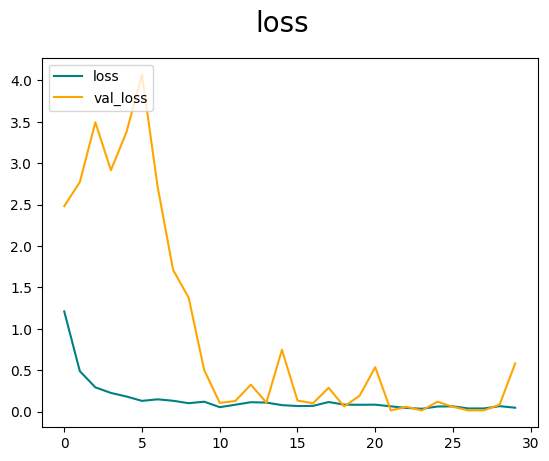

In [18]:
fig = plt.figure()
plt.plot(history.history['loss'],color = 'teal',label='loss')
plt.plot(history.history['val_loss'],color = 'orange',label='val_loss')
fig.suptitle('loss',fontsize=20)
plt.legend(loc='upper left')

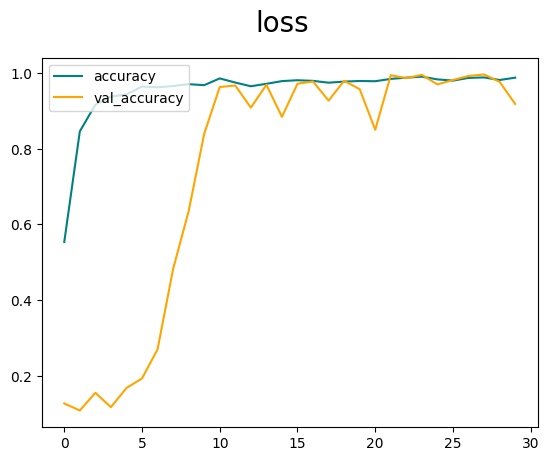

In [19]:
fig = plt.figure()
plt.plot(history.history['accuracy'],color = 'teal',label='accuracy')
plt.plot(history.history['val_accuracy'],color = 'orange',label='val_accuracy')
fig.suptitle('loss',fontsize=20)
plt.legend(loc='upper left')

In [20]:
classes = image_datasets[TEST].classes

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 373ms/step


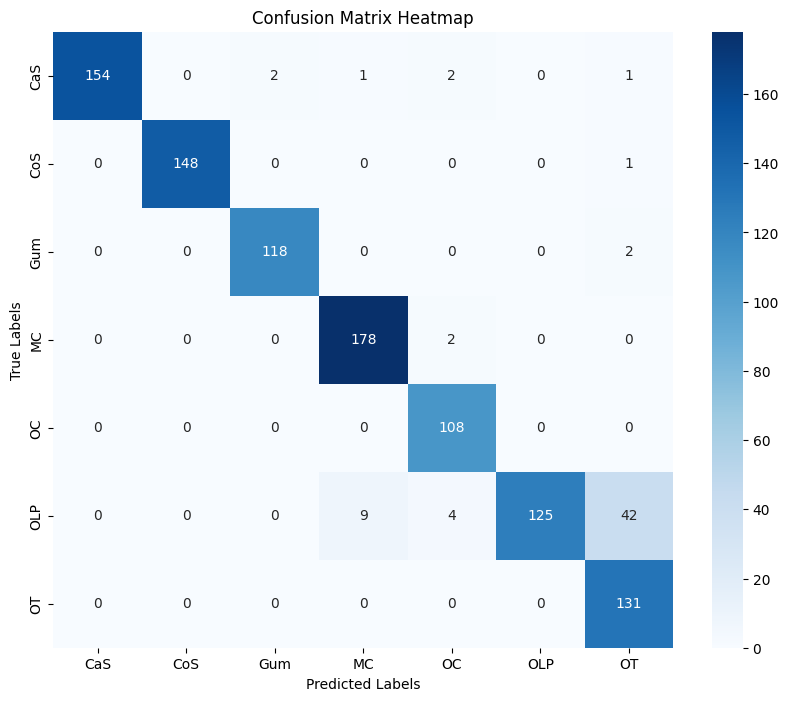

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

predict = model.predict(image_datasets[TEST])

predicted_classes = np.argmax(predict, axis=1)

conf_matrix = confusion_matrix(classes, predicted_classes)

class_names = list(class_names_label.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [22]:

print("Evaluating validation set:")
model.evaluate(image_datasets[VAL])

print("Evaluating test set : ")
model.evaluate(image_datasets[TEST])

Evaluating validation set:
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9379 - loss: 0.4907
Evaluating test set : 
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9634 - loss: 0.2169


[0.49069276452064514, 0.9357976913452148]

In [23]:
model.save('my_model.keras')